# StockBot
#### FDAC24 Final Project
Blake Milstead, Turner Heath, Karim Chmayssani

In [1]:
!pip install prophet --quiet
!pip install xgboost --quiet
!pip install fastparquet --quiet
!pip install --upgrade tensorflow>=2.17 --quiet
!pip install --upgrade keras --quiet
!pip install polygon-api-client --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data Collection and Preprocessing

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
url = 'https://raw.githubusercontent.com/fdac24/stock_bot/refs/heads/main/sentiment_stock_data.csv?token=GHSAT0AAAAAAC2KHNYQSYHEJZ2ENAU7CFAUZZ5FXEQ'

sentiment_data = pd.read_csv(url)

sentiment_data.columns = ['symbol', 'name', 'type', 'industry', 'date', 'headline', 'sentiment']

sentiment_data = sentiment_data.dropna()
sentiment_data = sentiment_data.reset_index(drop=True)

sentiment_data.head()

,symbol,name,type,industry,date,headline,sentiment
0,ONCY,Oncolytics Biotech Inc.,EQUITY,Healthcare,3/17/2011 11:33,Oncolytics Biotech Inc. Reports 2010 EPS of $(...,strongly bearish
1,DVAX,Dynavax Technologies Corporation,EQUITY,Healthcare,5/17/2018 18:06,Dynavax Shares Down 14.5%; Co. Reported SD-101...,mildly bearish
2,OHI,"Omega Healthcare Investors, Inc.",EQUITY,Real Estate,3/7/2017 13:20,Omega Healthcare Acquires Whitespace Healthcar...,mildly bullish
3,AIZ,"Assurant, Inc.",EQUITY,Financial Services,10/20/2015 20:23,8-K from Assurant Shows Prelim. Results for As...,mildly bearish
4,DGLY,"Digital Ally, Inc.",EQUITY,Communication Services,11/20/2017 20:59,Axon Enterprise Spokesperson Responds To Court...,strongly bearish


In [8]:
data_1 = pd.read_parquet('/content/drive/MyDrive/StockBot/stock_data_1.parquet', engine='fastparquet')
data_2 = pd.read_parquet('/content/drive/MyDrive/StockBot/stock_data_2.parquet', engine='fastparquet')

print(f'Subset data shapes are:\n\t{data_1.shape}\n\t{data_2.shape}')

stock_data = pd.concat([data_1, data_2], ignore_index=True).reset_index(drop=True)

print(f'Combined data shape is: {stock_data.shape}')

stock_data.head()

Subset data shapes are:
	(4202911, 8)
	(4202912, 8)
Combined data shape is: (8405823, 8)


,symbol,date,open,high,low,close,adj_close,volume
0,KAMN,1999-06-22,15.5000,15.56250,14.9375,15.00000,8.451834,51800.0
1,KAMN,1999-06-23,15.0625,15.25000,15.0625,15.21875,8.575084,29800.0
2,KAMN,1999-06-24,14.9375,15.09375,14.8750,15.00000,8.513368,29000.0
3,KAMN,1999-06-25,15.1250,16.00000,15.1250,15.62500,8.868090,47400.0
4,KAMN,1999-06-28,15.6250,15.68750,15.1250,15.25000,8.655251,10900.0


In [9]:
m_stock_data = stock_data[stock_data['symbol'].isin(sentiment_data['symbol'])]

time_col = pd.to_datetime(m_stock_data['date'])
m_stock_data = m_stock_data.assign(format_time = time_col.dt.strftime('%Y-%m-%d'))

m_stock_data = m_stock_data.sort_values(by='symbol').reset_index(drop=True)

m_stock_data.head()

,symbol,date,open,high,low,close,adj_close,volume,format_time
0,AAON,1992-12-16,0.066509,0.066509,0.066509,0.066509,0.050389,3759.0,1992-12-16
1,AAON,2013-06-21,9.508148,9.614815,9.084444,9.351111,8.379816,598388.0,2013-06-21
2,AAON,2013-06-20,9.520000,9.653333,9.333333,9.525926,8.536471,365513.0,2013-06-20
3,AAON,2013-06-19,9.792593,9.845926,9.668148,9.671111,8.666580,138713.0,2013-06-19
4,AAON,2013-06-18,9.594074,9.854815,9.534815,9.762963,8.748890,159638.0,2013-06-18


In [10]:
m_sentiment_data = sentiment_data[sentiment_data['symbol'].isin(m_stock_data['symbol'])]

time_col = pd.to_datetime(m_sentiment_data['date'])

m_sentiment_data = m_sentiment_data.assign(format_time = time_col.dt.strftime('%Y-%m-%d'))

sentiments = ['strongly bullish', 'mildly bullish', 'neutral', 'mildly bearish', 'strongly bearish']
sentiment_scale = np.linspace(0,1, len(sentiments))

sentiment_table = dict(zip(sentiments, sentiment_scale))

m_sentiment_data = m_sentiment_data.assign(s_val= [sentiment_table[sentiment] for sentiment in m_sentiment_data.sentiment])

m_sentiment_data = m_sentiment_data.sort_values(by='symbol').reset_index(drop=True)

m_sentiment_data.head()

,symbol,name,type,industry,date,headline,sentiment,format_time,s_val
0,AAON,"AAON, Inc.",EQUITY,Industrials,10/13/2016 11:05,"Jefferies Initiates Coverage On AAON, Inc. - C...",mildly bullish,2016-10-13,0.25
1,AAON,"AAON, Inc.",EQUITY,Industrials,8/8/2012 8:01,Top 4 Small-Cap Stocks In The General Building...,mildly bullish,2012-08-08,0.25
2,AAON,"AAON, Inc.",EQUITY,Industrials,5/5/2014 13:45,Morning Market Movers,neutral,2014-05-05,0.50
3,AAON,"AAON, Inc.",EQUITY,Industrials,5/5/2011 11:11,AAON Reports 3-for-2 Stock Split (AAON),neutral,2011-05-05,0.50
4,AAON,"AAON, Inc.",EQUITY,Industrials,2/11/2020 15:17,Stocks That Hit 52-Week Highs On Tuesday,mildly bullish,2020-02-11,0.25


In [11]:
tickers = m_stock_data.symbol.unique()

data = {}

for i in range(len(tickers)):
    t = tickers[i]
    t_sentiment_data = m_sentiment_data[m_sentiment_data['symbol'].isin([t])].reset_index(drop=True)
    t_stock_data = m_stock_data[m_stock_data['symbol'].isin([t])]

    dates = t_sentiment_data['format_time'].unique()
    d_m_stock_data = t_stock_data[t_stock_data['format_time'].isin(dates)].reset_index(drop=True)

    dates_final = pd.to_datetime(d_m_stock_data['format_time'].unique())

    d_m_stock_data['format_time'] = pd.to_datetime(d_m_stock_data['format_time'])
    t_sentiment_data['format_time'] = pd.to_datetime(t_sentiment_data['format_time'])

    d_m_stock_data = d_m_stock_data.sort_values(by='format_time', ascending=True).reset_index(drop=True)
    t_sentiment_data = t_sentiment_data.sort_values(by='format_time', ascending=True).reset_index(drop=True)

    d_m_sentiment_data = t_sentiment_data[t_sentiment_data['format_time'].isin(dates_final)].drop_duplicates(subset='format_time', keep='first').reset_index(drop=True)

    data[t] = pd.concat((d_m_sentiment_data['s_val'], d_m_stock_data[['open', 'close', 'high', 'low', 'format_time']]), axis=1)

print(data.head())

{'AAON':     s_val       open      close       high        low format_time
0    0.25   4.965926   4.960000   5.007407   4.904691  2010-11-15
1    0.50   6.251852   6.340741   6.518519   6.097778  2011-05-05
2    0.50   5.668148   5.730370   5.745185   5.582222  2012-05-21
3    0.25   5.801481   5.851852   5.952593   5.757037  2012-08-08
4    0.50  13.320000  14.031111  14.186667  13.320000  2014-05-05
5    0.25  11.620000  11.693333  12.100000  11.460000  2014-10-14
6    0.75  13.033333  13.913333  13.920000  12.766667  2014-11-06
7    0.50  15.833333  15.006667  15.900000  14.973333  2015-02-27
8    0.75  14.313333  15.206667  15.326667  14.313333  2015-08-06
9    0.25  19.666668  19.533333  19.666668  19.366667  2016-10-13
10   0.75  21.666668  21.299999  22.853333  20.066668  2017-02-23
11   0.25  36.639999  36.740002  37.459999  36.480000  2020-02-11
12   0.50  32.666668  31.299999  33.119999  30.946667  2020-04-07
13   0.25  31.700001  31.833332  31.913334  30.740000  2020-05-15, 

In [13]:
look_back = 10  # Number of previous days to consider

# Create a dataset with lookback
def create_dataset(dataset, look_back=look_back):
    X, Y = [], []
    if len(dataset) < look_back + 2:  # + 2 for look_back and at least one target
        return np.empty((0, look_back, dataset.shape[1])), np.empty((0,))  # Return empty arrays with correct shape
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [14]:
from sklearn.preprocessing import MinMaxScaler

min_data_points = look_back + 2  # Minimum data points needed (lookback + target + 1 for reshaping)

suitable_tickers = []
for ticker in data:
    if len(data[ticker]) >= min_data_points:
        # Check if enough data to create a dataset, reshape it, and split for training and testing
        dataset = data[ticker][['close', 's_val', 'open', 'high', 'low']].values
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset)

        train_size = int(len(dataset) * 0.8)
        train_data, test_data = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

        X_train, Y_train = create_dataset(train_data, look_back)
        X_test, Y_test = create_dataset(test_data, look_back)  # Check test data

        # Check if both X_train and X_test have sufficient data
        if X_train.size > 0 and X_train.shape[0] > 0 and X_train.shape[1] > 0 and X_train.shape[2] > 0 and \
           X_test.size > 0 and X_test.shape[0] > 0 and X_test.shape[1] > 0 and X_test.shape[2] > 0:
            suitable_tickers.append(ticker)
filtered_data = {ticker: data[ticker] for ticker in suitable_tickers if ticker in data}

data = filtered_data

print("Tickers with sufficient data:", suitable_tickers, "\nNumber of tickers with sufficient data:", len(suitable_tickers))

Tickers with sufficient data: ['ABBV', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AFL', 'AGCO', 'AIG', 'AJG', 'ALB', 'ALK', 'ALL', 'ALV', 'AMAT', 'AMT', 'AN', 'ATI', 'ATVI', 'AU', 'AVGO', 'AXL', 'AXP', 'AZO', 'BAC', 'BAX', 'BDX', 'BG', 'BIIB', 'BK', 'BLK', 'BMY', 'BSX', 'BWA', 'BX', 'BYD', 'BZH', 'C', 'CACI', 'CAG', 'CCI', 'CCL', 'CF', 'CHD', 'CHS', 'CI', 'CIEN', 'CL', 'CLF', 'CLNE', 'CLX', 'CMA', 'CMC', 'CMCSA', 'CME', 'CMG', 'CMI', 'CNC', 'CNI', 'COF', 'COO', 'COP', 'CPB', 'CRM', 'CROX', 'CSCO', 'CSX', 'CTSH', 'CVS', 'D', 'DAL', 'DD', 'DDD', 'DE', 'DFS', 'DG', 'DGLY', 'DGX', 'DHI', 'DHR', 'DKS', 'DLTR', 'DOV', 'DPZ', 'DRI', 'DUK', 'DVA', 'DVN', 'DXCM', 'EA', 'EBAY', 'ED', 'EL', 'EMR', 'ENPH', 'EOG', 'EQIX', 'EQT', 'ETN', 'ETR', 'EW', 'EXPE', 'F', 'FCEL', 'FCX', 'FDX', 'FE', 'FIS', 'FITB', 'FIVE', 'FMC', 'FSLR', 'FTNT', 'GD', 'GILD', 'GIS', 'GME', 'GOOG', 'GOOGL', 'GPN', 'GRMN', 'GWW', 'HAIN', 'HAL', 'HAS', 'HBAN', 'HCA', 'HD', 'HIG', 'HMC', 'HOLX', 'HSY', 'HUM', 'IBM', 'ICE', 'IEP'

Using Polygon.Io API

In [15]:
import time
from datetime import date, timedelta
from polygon import RESTClient
from requests.exceptions import HTTPError

# Set your Polygon.io API key
api_key = 'WlyapBrEd4Rq_3c7UKjic7C13QSirasy'  # Replace with your actual API key

# Assuming 'suitable_tickers' is your list of stock tickers
# Assuming you have functionality or API to get daily sentiment score for a ticker using external sentiment analysis

def get_daily_sentiment(ticker, date_str):
    # Placeholder for your actual sentiment analysis
    sentiment_score = 0.5  # Replace with actual sentiment value or calculation
    return sentiment_score

def create_stock_sentiment_df(ticker):
    client = RESTClient(api_key=api_key)
    today = date.today()
    from_date = today - timedelta(days=365)
    to_date = today

    # Function to make the API call with retries
    def make_api_call():
        attempts = 0
        while attempts < 3:  # Retry up to 3 times
            try:
                aggs = client.list_aggs(
                    ticker=ticker,
                    multiplier=1,
                    timespan="day",
                    from_=from_date,
                    to=to_date,
                    limit=50000  # Adjust limit as needed
                )
                return aggs  # Return the data if successful
            except HTTPError as e:
                if e.response.status_code == 429:  # Rate limit error
                    print(f"Rate limit hit for {ticker}. Retrying in 60 seconds...")
                    time.sleep(60)  # Wait for 60 seconds
                    attempts += 1
                else:
                    raise  # Raise other errors for handling outside

        print(f"Failed to fetch data for {ticker} after multiple retries.")
        return None  # Return None if all retries fail

    aggs = make_api_call()  # Call the API with retries

    if aggs is None:
        return pd.DataFrame()  # Return empty DataFrame if API call failed

    stock_df = pd.DataFrame(aggs)
    if stock_df.empty:
        print(f"No data found for ticker: {ticker}")
        return pd.DataFrame()

    stock_df = stock_df.rename(columns={"timestamp": "time"})
    stock_df['Datetime'] = pd.to_datetime(stock_df['time'], unit='ms', utc=True).dt.tz_convert('America/New_York')
    stock_df['sentiment'] = stock_df['time'].apply(lambda timestamp: get_daily_sentiment(ticker, pd.to_datetime(timestamp, unit='ms').strftime('%Y-%m-%d')))

    return stock_df

# Create a dictionary to store DataFrames for each ticker
all_ticker_data = {}
test_tickers = ['ABBV','ADI','GOOGL','YUM']
# Loop through suitable tickers with rate limiting
for i, ticker in enumerate(test_tickers):
    df = create_stock_sentiment_df(ticker)
    if not df.empty:
        all_ticker_data[ticker] = df

    if (i + 1) % 5 == 0:  # Every 5 requests, pause for 60 seconds
        print("Pausing for 60 seconds to respect rate limits...")
        time.sleep(60)

# Example: Print the DataFrame for one ticker
print(all_ticker_data['GOOGL'])  # Replace 'AAPL' with a ticker in your list

       open     high       low   close      volume      vwap           time  \
0    133.69  136.660  133.6200  136.25  27850762.0  135.7784  1700456400000   
1    136.29  137.180  135.9600  136.97  22628522.0  136.6908  1700542800000   
2    137.47  139.420  137.4700  138.49  17620456.0  138.4474  1700629200000   
3    138.03  138.130  135.9900  136.69  12514322.0  136.7806  1700802000000   
4    136.03  138.420  136.0000  136.41  23436526.0  136.7408  1701061200000   
..      ...      ...       ...     ...         ...       ...            ...   
246  179.82  182.490  179.3900  181.62  23771691.0  181.2091  1731387600000   
247  180.46  180.960  178.5400  178.88  20219823.0  179.3087  1731474000000   
248  178.28  178.820  174.3218  175.58  28361543.0  175.7219  1731560400000   
249  173.73  174.140  171.2200  172.49  30508847.0  172.4569  1731646800000   
250  173.42  175.438  172.9000  175.30  17997254.0  174.5173  1731906000000   

     transactions   otc                  Datetime  

In [16]:
print(all_ticker_data['ABBV'])

       open     high     low   close      volume      vwap           time  \
0    137.53  138.690  137.14  138.31   4490104.0  138.1784  1700456400000   
1    138.73  139.360  137.83  138.73   4690970.0  138.6401  1700542800000   
2    139.06  139.840  138.33  138.47   3428670.0  138.7427  1700629200000   
3    140.00  140.080  138.46  138.67   1636535.0  138.8256  1700802000000   
4    138.70  139.375  137.79  139.09   5529373.0  138.7590  1701061200000   
..      ...      ...     ...     ...         ...       ...            ...   
246  176.01  176.630  171.03  171.09  10497271.0  173.2397  1731387600000   
247  171.67  172.640  169.65  170.35   8028032.0  170.7969  1731474000000   
248  170.00  171.620  168.59  169.63   6857201.0  170.1246  1731560400000   
249  169.63  169.630  164.72  164.99  10943281.0  166.1697  1731646800000   
250  165.62  166.740  164.80  166.28   6733627.0  165.9180  1731906000000   

     transactions   otc                  Datetime  sentiment  
0           

**Model Experimentation**



Feature Importances for Ticker: ABBV
s_val: 0.0007
open: 0.3041
high: 0.2863
low: 0.4088

Feature Importances for Ticker: ACN
s_val: 0.0004
open: 0.3526
high: 0.3126
low: 0.3344

Feature Importances for Ticker: ADBE
s_val: 0.0002
open: 0.3796
high: 0.3676
low: 0.2527

Feature Importances for Ticker: ADI
s_val: 0.0002
open: 0.3836
high: 0.3547
low: 0.2614

Feature Importances for Ticker: ADM
s_val: 0.0011
open: 0.3621
high: 0.3361
low: 0.3007

Feature Importances for Ticker: ADP
s_val: 0.0009
open: 0.3831
high: 0.3010
low: 0.3150

Feature Importances for Ticker: ADSK
s_val: 0.0001
open: 0.3502
high: 0.3631
low: 0.2866

Feature Importances for Ticker: AFL
s_val: 0.0009
open: 0.3592
high: 0.3477
low: 0.2923

Feature Importances for Ticker: AGCO
s_val: 0.0014
open: 0.3163
high: 0.3321
low: 0.3502

Feature Importances for Ticker: AIG
s_val: 0.0002
open: 0.3521
high: 0.2982
low: 0.3496

Feature Importances for Ticker: AJG
s_val: 0.0002
open: 0.3899
high: 0.3204
low: 0.2895

Feature Importan

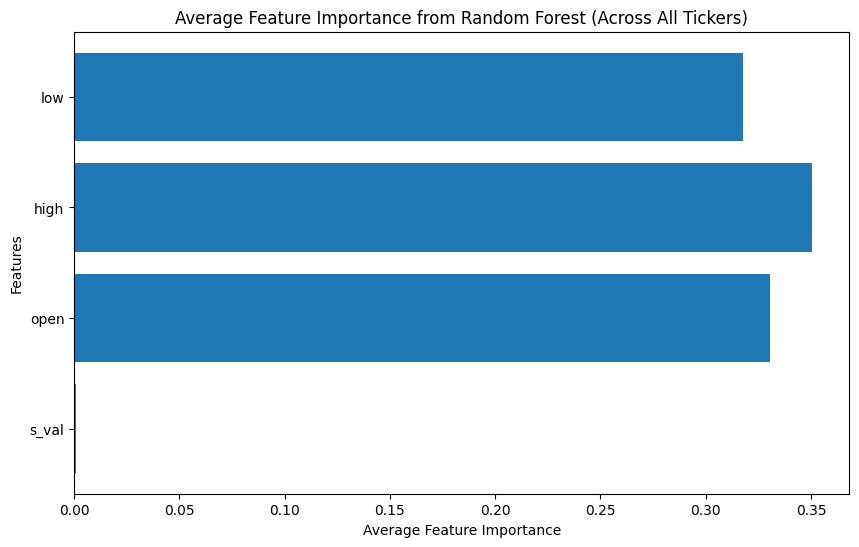

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Assuming 'data' is your dictionary containing data for all suitable tickers
features = ['s_val', 'open', 'high', 'low']  # Adjust features as needed
target = 'close'

all_feature_importances = {}  # Store feature importances for all tickers

for ticker in suitable_tickers:
    df = data[ticker]  # Get data for the current ticker

    # Data preparation (same as before)
    X = df[features].values
    y = df[target].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Random Forest model training (same as before)
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Get feature importances
    feature_importances = rf_model.feature_importances_

    # Store feature importances for the current ticker
    all_feature_importances[ticker] = feature_importances

    # Print feature importances for the current ticker
    print(f"\nFeature Importances for Ticker: {ticker}")
    for i, feature in enumerate(features):
        print(f"{feature}: {feature_importances[i]:.4f}")

# Visualize average feature importances across all tickers
avg_feature_importances = np.mean(list(all_feature_importances.values()), axis=0)

plt.figure(figsize=(10, 6))
plt.barh(features, avg_feature_importances)
plt.xlabel('Average Feature Importance')
plt.ylabel('Features')
plt.title('Average Feature Importance from Random Forest (Across All Tickers)')
plt.show()

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber

# Assuming 'data' dictionary contains your preprocessed data

# Select a ticker symbol for prediction
ticker = 'GOOGL'
df = data[ticker]

# Prepare the data for LSTM
dataset = df[['close', 's_val', 'open', 'high', 'low']].values
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split into train and test sets
train_size = int(len(dataset) * 0.8)
train_data, test_data = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

print("X_train shape after create_dataset:", X_train.shape)
print("X_test shape after create_dataset:", X_test.shape)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)))  # Add L2 regularization to the kernel
model.add(LSTM(units=50, kernel_regularizer=l2(0.01)))  # Add L2 regularization to the kernel
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32)

# Make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# Invert predictions to get actual values
trainPredict = scaler.inverse_transform(np.concatenate((trainPredict.reshape(-1, 1), np.zeros((trainPredict.shape[0], dataset.shape[1] - 1))), axis=1))[:,0]
Y_train = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], dataset.shape[1] - 1))), axis=1))[:,0]
testPredict = scaler.inverse_transform(np.concatenate((testPredict.reshape(-1, 1), np.zeros((testPredict.shape[0], dataset.shape[1] - 1))), axis=1))[:,0]
Y_test = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], dataset.shape[1] - 1))), axis=1))[:,0]
print(trainPredict)
print(Y_train)
print(testPredict)
print(Y_test)

X_train shape after create_dataset: (110, 10, 5)
X_test shape after create_dataset: (20, 10, 5)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.1639
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9155
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8330
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7964
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7277
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6807
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6380
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5965
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.5542
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5195
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4858
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.4492
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.4218
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3946 
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3680 
Epoch 16/100
4/4 

Train Score: 2.36 RMSE
Test Score: 2.68 RMSE
Train R-squared: 0.89
Test R-squared: 0.62


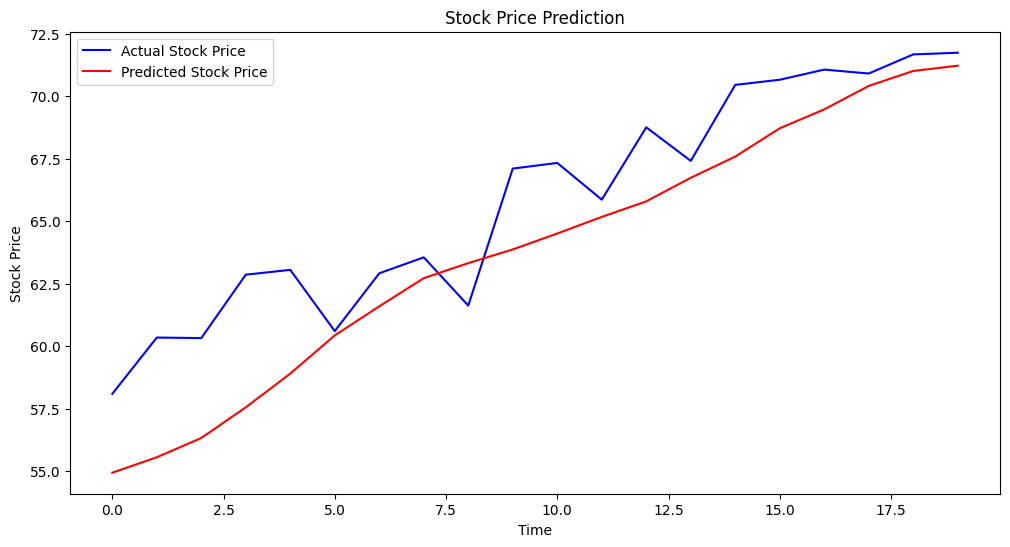

In [19]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# ... (previous code for LSTM model building and prediction) ...

# Calculate root mean squared error (RMSE)
trainScore = np.sqrt(mean_squared_error(Y_train, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(Y_test, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

# Calculate R-squared score
trainR2 = r2_score(Y_train, trainPredict)
print('Train R-squared: %.2f' % (trainR2))
testR2 = r2_score(Y_test, testPredict)
print('Test R-squared: %.2f' % (testR2))

# Plot the predicted vs. actual values
plt.figure(figsize=(12, 6))
plt.plot(Y_test, color='blue', label='Actual Stock Price')
plt.plot(testPredict, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [20]:
def quantile_loss(y_true, y_pred, quantile=0.5):
    error = y_true - y_pred
    return tf.keras.backend.mean(tf.keras.backend.maximum(quantile * error, (quantile - 1) * error), axis=-1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkmovvwyk/_seonqfl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkmovvwyk/3kkeh525.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13512', 'data', 'file=/tmp/tmpkmovvwyk/_seonqfl.json', 'init=/tmp/tmpkmovvwyk/3kkeh525.json', 'output', 'file=/tmp/tmpkmovvwyk/prophet_model5lkniooi/prophet_model-20241119234032.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:40:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:40:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-21-27b63825f61b>:70: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future['sentiment'] = future['sentiment'].fillna(method='ffill')  # Us

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkmovvwyk/9zrh17xq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkmovvwyk/fqc20a3g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59375', 'data', 'file=/tmp/tmpkmovvwyk/9zrh17xq.json', 'init=/tmp/tmpkmovvwyk/fqc20a3g.json', 'output', 'file=/tmp/tmpkmovvwyk/prophet_model6ir4p54e/prophet_model-20241119234124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:41:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:41:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-21-27b63825f61b>:70: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future['sentiment'] = future['sentiment'].fillna(method='ffill')  # Use

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


DEBUG:cmdstanpy:input tempfile: /tmp/tmpkmovvwyk/ur5bm6ev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkmovvwyk/9u8j8b4g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35478', 'data', 'file=/tmp/tmpkmovvwyk/ur5bm6ev.json', 'init=/tmp/tmpkmovvwyk/9u8j8b4g.json', 'output', 'file=/tmp/tmpkmovvwyk/prophet_modeldrt5xfw1/prophet_model-20241119234217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:42:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:42:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
<ipython-input-21-27b63825f61b>:70: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future['sentiment'] = future['sentiment'].fillna(method='ffill')  # Use

   Ticker    Model Loss Function  Train Score  Test Score
0    ABBV     LSTM           mae     6.276148    2.713649
1    ABBV     LSTM           mse     8.094100    4.756909
2    ABBV     LSTM         huber     9.297613    7.315533
3    ABBV     LSTM      quantile     8.556347    1.532362
4    ABBV  Prophet          None          NaN   21.644905
5    ABBV  XGBoost          rmse          NaN    2.363380
6    ABBV  XGBoost           mae          NaN    2.363380
7   GOOGL     LSTM           mae     2.641084    2.320279
8   GOOGL     LSTM           mse     2.628423    2.631392
9   GOOGL     LSTM         huber     3.061050    4.228025
10  GOOGL     LSTM      quantile     2.261416    2.614762
11  GOOGL  Prophet          None          NaN   37.735595
12  GOOGL  XGBoost          rmse          NaN    0.812076
13  GOOGL  XGBoost           mae          NaN    0.812076
14    YUM     LSTM           mae     3.732339   17.296207
15    YUM     LSTM           mse     4.845270   21.800077
16    YUM     

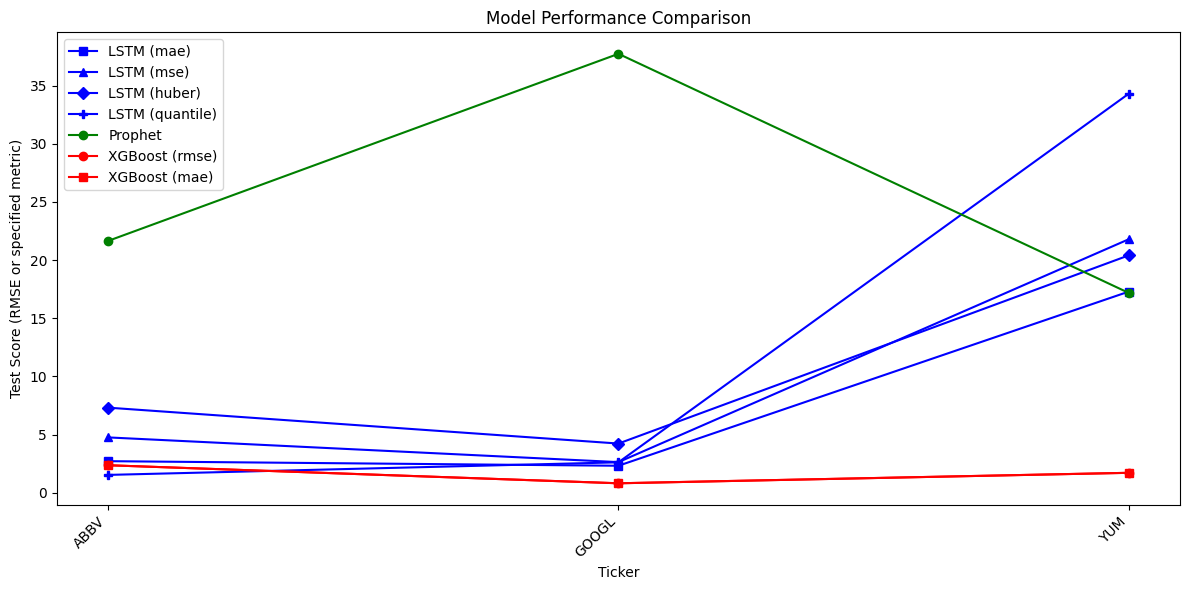

In [21]:
from prophet import Prophet
import xgboost as xgb
def train_and_evaluate_model(model_type, loss_function=None, ticker='YUM', look_back=10, epochs=100, batch_size=32):
    df = data[ticker]

    if model_type == 'LSTM':

      dataset = df[['close', 's_val', 'open', 'high', 'low']].values
      scaler = MinMaxScaler(feature_range=(0, 1))
      dataset = scaler.fit_transform(dataset)

      train_size = int(len(dataset) * 0.8)
      train_data, test_data = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

      def create_dataset(dataset, look_back=look_back):
          X, Y = [], []
          for i in range(len(dataset) - look_back - 1):
              a = dataset[i:(i + look_back), :]
              X.append(a)
              Y.append(dataset[i + look_back, 0])
          return np.array(X), np.array(Y)

      X_train, Y_train = create_dataset(train_data)
      X_test, Y_test = create_dataset(test_data)

      X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
      X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

      model = Sequential()
      model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)))
      model.add(LSTM(units=50, kernel_regularizer=l2(0.01)))
      model.add(Dense(1))

      if loss_function == 'quantile':
        model.compile(loss=lambda y_true, y_pred: quantile_loss(y_true, y_pred, quantile=0.5), optimizer='adam')
      else:
        model.compile(loss=loss_function, optimizer='adam')

      model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=0)

      trainPredict = model.predict(X_train)
      testPredict = model.predict(X_test)

      trainPredict = scaler.inverse_transform(np.concatenate((trainPredict, np.zeros((trainPredict.shape[0], dataset.shape[1] - 1))), axis=1))[:, 0]
      Y_train_orig = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], dataset.shape[1] - 1))), axis=1))[:, 0]
      testPredict = scaler.inverse_transform(np.concatenate((testPredict, np.zeros((testPredict.shape[0], dataset.shape[1] - 1))), axis=1))[:, 0]
      Y_test_orig = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], dataset.shape[1] - 1))), axis=1))[:, 0]

      train_score = np.sqrt(mean_squared_error(Y_train_orig, trainPredict))  # RMSE
      test_score = np.sqrt(mean_squared_error(Y_test_orig, testPredict))  # RMSE

    elif model_type == 'Prophet':
        prophet_df = df[['format_time', 'close']].copy()
        prophet_df.columns = ['ds', 'y']
        prophet_df['sentiment'] = df['s_val']

        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,  # Disable weekly seasonality
            daily_seasonality=False,   # Disable daily seasonality
            seasonality_mode='multiplicative',  # Use multiplicative seasonality
            changepoint_prior_scale=0.5,  # Adjust trend flexibility
        )
        model.add_regressor('sentiment')
        model.fit(prophet_df)

        future = model.make_future_dataframe(periods=len(df['s_val']))
        # Extend sentiment values to the future dataframe for all periods
        future['sentiment'] = data[ticker]['s_val']
        future['sentiment'] = future['sentiment'].fillna(method='ffill')  # Use Forward Fill to handle NaN

        forecast = model.predict(future)

        y_pred = forecast['yhat'][-30:].values
        y_true = df['close'].iloc[-30:].values

        train_score = np.nan  # Prophet doesn't have a separate training score
        test_score = np.sqrt(mean_squared_error(y_true, y_pred))

    elif model_type == 'XGBoost':
        features = ['s_val', 'open', 'high', 'low']  # Adjust features as needed
        target = 'close'

        X = df[features]
        y = df[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Define objective function based on loss_function parameter
        objective = 'reg:squarederror'  # Default objective
        if loss_function == 'rmse':
            objective = 'reg:squarederror'  # RMSE is the default metric for 'reg:squarederror'
        elif loss_function == 'mae':
            objective = 'reg:linear'  # Use 'reg:linear' for MAE
        # Add more objective options if needed

        model = xgb.XGBRegressor(objective=objective,
                                  n_estimators=100,
                                  learning_rate=0.1,
                                  max_depth=3)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        train_score = np.nan  # XGBoost doesn't have a separate training score in this setup
        test_score = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculate RMSE

    else:
        raise ValueError(f"Invalid model_type: {model_type}")

    return train_score, test_score

# Define the loss functions
# Define the models and loss functions to compare
models = {
    'LSTM': {
         'loss_functions': ['mae', 'mse', 'huber', 'quantile']
    },
    'Prophet': {
         # Prophet doesn't use these loss functions
    },
    'XGBoost': {
        'loss_functions': ['rmse', 'mae'] # XGBoost doesn't use these loss functions
    }
}

# Store the results for all tickers and models
all_results = {}

test_tickers = ['ABBV','GOOGL', 'YUM']

for ticker in test_tickers:
    all_results[ticker] = {}  # Initialize results for the current ticker
    for model_type, model_config in models.items():

        all_results[ticker][model_type] = {}  # Initialize results for the current modela

        if model_type == 'Prophet':
          train_score, test_score = train_and_evaluate_model(model_type, loss_function=None, ticker=ticker)  # No loss function for Prophet
          all_results[ticker][model_type] = {'train_score': train_score, 'test_score': test_score}

        # Train and evaluate models for different loss functions
        else:
          for loss_function in model_config.get('loss_functions', []):  # Handle cases where loss_functions might not be defined for a model
              train_score, test_score = train_and_evaluate_model(model_type, loss_function, ticker)
              all_results[ticker][model_type][loss_function] = {'train_score': train_score, 'test_score': test_score}

# Print the results
results_data = []
for ticker, ticker_results in all_results.items():
    for model_type, model_results in ticker_results.items():
        if model_type != 'Prophet':  # Check if model_results is a dictionary (for LSTM, XGBoost)
            for loss_function, scores in model_results.items():
                results_data.append([ticker, model_type, loss_function, scores['train_score'], scores['test_score']])
        elif model_type == 'Prophet':  # Handle Prophet separately
            # Assuming Prophet results are stored as: {'train_score': value, 'test_score': value}
            results_data.append([ticker, model_type, None, model_results['train_score'], model_results['test_score']])  # Append scores with None for loss function

results_df = pd.DataFrame(results_data, columns=['Ticker', 'Model', 'Loss Function', 'Train Score', 'Test Score'])
print(results_df)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Define colors for each model
model_colors = {'LSTM': 'blue', 'Prophet': 'green', 'XGBoost': 'red'}

loss_function_markers = {
    'rmse': 'o',
    'mae': 's',
    'mse': '^',
    'huber': 'D',  # Diamond marker for Huber
    'quantile': 'P'   # Plus marker for Quantile
}

for model_type, model_config in models.items():
    print(f"Processing model type: {model_type}")  # Print for debugging

    # Get loss functions or a placeholder list for Prophet
    loss_functions = model_config.get('loss_functions', [None])  # [None] for Prophet

    for loss_function in loss_functions:
        if model_type == 'Prophet':
            label = 'Prophet'  # Single label for Prophet
        else:
            label = f"{model_type} ({loss_function})"

        # Change loss_function to lowercase for comparison
        loss_key = loss_function.lower() if loss_function else None

        if loss_key in loss_function_markers or model_type == 'Prophet':
            test_scores = []
            for ticker in test_tickers:
                try:
                    # Extract test score using get with nested dictionaries and default to np.nan for missing values
                    score = all_results.get(ticker, {}).get(model_type, {}).get(loss_function, {}).get('test_score', np.nan) if model_type != "Prophet" else all_results.get(ticker, {}).get(model_type, {}).get('test_score', np.nan)
                except (KeyError, TypeError):
                    score = np.nan  # Handle cases where the key or the type is not as expected
                test_scores.append(score)

            print(f"Model: {model_type}, Loss: {loss_function}, Scores shape: {np.shape(test_scores)}, Scores: {test_scores}")  # Print for debugging
            print(f"test_tickers: {np.shape(test_tickers)}, test_tickers: {test_tickers}")

            # Plotting
            ax.plot(test_tickers, test_scores, marker=loss_function_markers.get(loss_key, 'o'), color=model_colors[model_type], label=label)


# Customize the plot
ax.set_xlabel("Ticker")
ax.set_ylabel("Test Score (RMSE or specified metric)")
ax.set_title("Model Performance Comparison")
ax.legend()
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()


In [291]:
class stock_bot():

    def __init__(self, ticker, api_key, days_back, random_state, features=None):
        if features is None:
          features = ['open', 'high', 'low', 'close', 'volume']
        self.features = features
        self.ticker = ticker
        self.random_state = random_state
        self.data = self.create_stock_sentiment_df(api_key, days_back)[self.features]
        self.models = {}

        for target in self.features:
          self.train(target)

    def get_features(self, target):
        return [f for f in self.features if f != target]

    def get_daily_sentiment(self, ticker, date):
      return 0.5

    def make_api_call(self, client, from_date, to_date):
        # Function to make the API call with retries
        attempts = 0
        while attempts < 3:  # Retry up to 3 times
            try:
                aggs = client.list_aggs(
                    ticker=self.ticker,
                    multiplier=1,
                    timespan="day",
                    from_=from_date,
                    to=to_date,
                    limit=50000  # Adjust limit as needed
                )
                return aggs  # Return the data if successful
            except HTTPError as e:
                if e.response.status_code == 429:  # Rate limit error
                    print(f"Rate limit hit for {self.ticker}. Retrying in 60 seconds...")
                    time.sleep(60)  # Wait for 60 seconds
                    attempts += 1
                else:
                    raise  # Raise other errors for handling outside
        print(f"Failed to fetch data for {self.ticker} after multiple retries.")
        return None  # Return None if all retries fail

    def create_stock_sentiment_df(self, api_key, days_back=365):
        client = RESTClient(api_key=api_key)
        today = date.today()
        from_date = today - timedelta(days=days_back)
        to_date = today

        aggs = self.make_api_call(client, from_date, to_date)  # Call the API with retries

        if aggs is None:
            return pd.DataFrame()  # Return empty DataFrame if API call failed

        stock_df = pd.DataFrame(aggs)
        if stock_df.empty:
            print(f"No data found for ticker: {self.ticker}")
            return pd.DataFrame()

        stock_df = stock_df.rename(columns={"timestamp": "time"})
        stock_df['Datetime'] = pd.to_datetime(stock_df['time'], unit='ms', utc=True).dt.tz_convert('America/New_York')
        stock_df['sentiment'] = stock_df['time'].apply(lambda timestamp: self.get_daily_sentiment(self.ticker, pd.to_datetime(timestamp, unit='ms').strftime('%Y-%m-%d')))

        return stock_df

    def train(self, target):
        X = self.data.loc[:, self.get_features(target)]
        y = self.data[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=self.random_state)

        # Define objective function based on loss_function parameter
        objective = 'reg:squarederror'  # Default objective
        # Add more objective options if needed

        model = xgb.XGBRegressor(objective=objective,
                                  n_estimators=100,
                                  learning_rate=0.1,
                                  max_depth=3)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        train_score = np.nan  # XGBoost doesn't have a separate training score in this setup
        test_score = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculate RMSE

        self.models[target] = model

        return model, test_score

    def plot(self, model):
        plt.figure(figsize=(12, 6))
        plt.plot(self.data['Datetime'], self.data['close'], label='Actual Stock Price', color='blue')

        plt.plot(self.data['Datetime'], model.predict(self.data[self.features]), label='Predicted Stock Price', color='red')
        plt.title(f'Stock Price Prediction for {self.ticker}')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()

    def predict_day(self, yesterday):
        today = {}
        y_data_open = yesterday[self.get_features('open')]


        # Reshape the features into a 2D array for prediction
        t_open_pred = y_data_open.values.reshape(1, -1)

        # Predict the 'open' price using the appropriate model
        today_open = self.models['open'].predict(t_open_pred)[0]

        today['open'] = today_open

        for target in self.features:
          if target != 'open' and target != 'close':
            model = self.models[target]
            target_features = self.get_features(target)
            last_day_target = yesterday[target_features].copy()
            last_day_target['open'] = today['open']

            last_day_target_pred = last_day_target.values.reshape(1, -1)
            # Predict the target price using the appropriate model
            today_target = model.predict(last_day_target_pred)[0]

            today[target] = today_target

        close_model = self.models['close']
        today_close = close_model.predict(pd.DataFrame([today]))[0]
        today['close'] = today_close

        idx = range(len(self.features) - 1)

        today = pd.DataFrame([today], columns=self.features)

        return today

    def predict_x(self, x):
        last_data_day = self.data.iloc[-1].to_frame().transpose()
        data = {}
        closes = []

        for i in range(x):
          today = self.predict_day(last_data_day)
          data[i] = today
          closes.append(data[i]['close'])
          last_data_day = today

        return data, closes

    def plot_x(self, days_b4, closes):

        days = self.data.tail(days_b4)['close'].reset_index(drop=True)

        plot = np.concatenate((days.values.flatten(), np.array(closes).flatten()))

        plt.figure(figsize=(12, 6))
        plt.plot(np.linspace(1,len(closes) + days_b4,len(closes) + days_b4), plot, label='Predicted Closing Price', color='green')
        plt.title(f'{len(closes)} Day Closing Price Prediction for {self.ticker}')
        plt.xlabel('Days')
        plt.ylabel('Closing Price')
        plt.legend()

        plt.show()

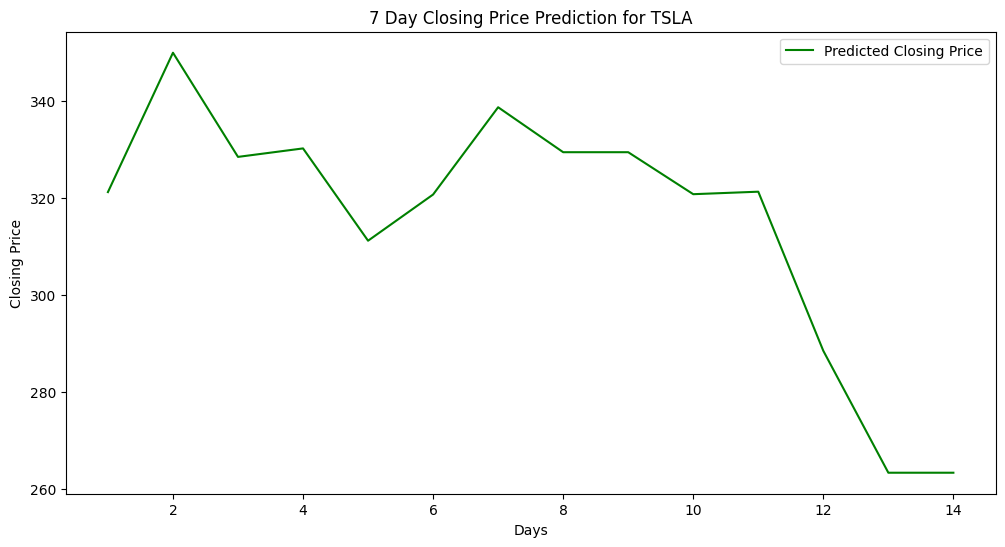

In [293]:
days_back = 365

bot = stock_bot('TSLA', api_key, days_back, 42)

week, week_close = bot.predict_x(7)

bot.plot_x(7, week_close)

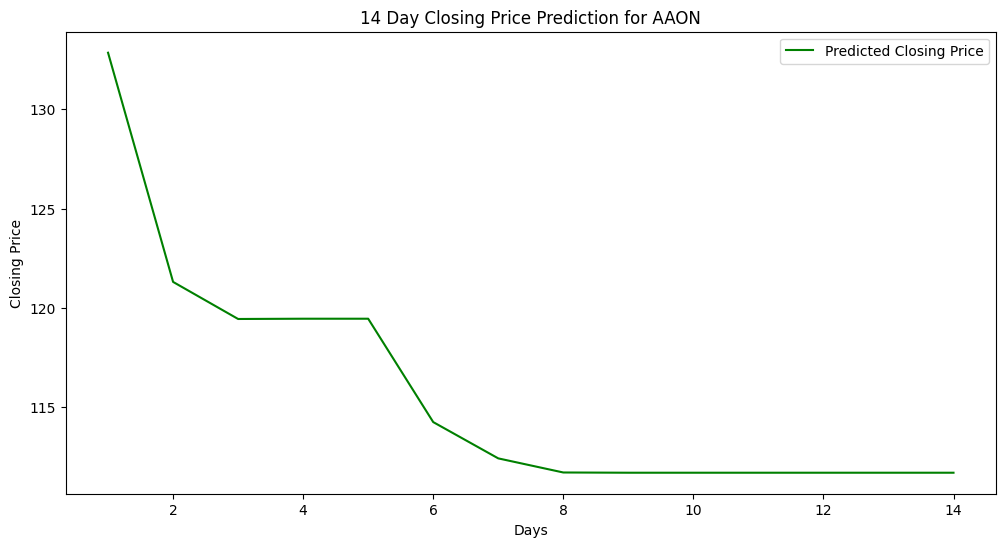

In [250]:
days_back = 365

bot = stock_bot('AAON', api_key, days_back, 42)

week = bot.predict_x(14)